Task: Study the various Recommendation Techniques for recommending movies using
movies.csv, ratings.csv datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD, NMF

# Load dataset


In [2]:
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')

### Data set Description for ratings.csv

UserId: A unique Id represents every user

movieId: Unique ID representing a movie

Rating: Represents the rating given by the user to the coreesponding movie

timestamp: The time at which the rating was recorded

In [3]:
ratings_df.info()
ratings_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Data set Description for movies.csv

movieId: Unique ID representing a movie

title: Movie name which is represented by the corresponding movieId

genre: Represents the category of the movie

timestamp: The time at which the rating was recorded

In [4]:
movies_df.info()
movies_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Merge both data frames on movieid


In [5]:
df = pd.merge(ratings_df, movies_df, on='movieId')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


In [6]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Combined dataframe is 100836 rows and 6 columns

### Genres of Movies

In [7]:
genres = {}

def find_genres():
    for genre in df['genres']:
        words = genre.split('|')
        for word in words:
            genres[word] = genres.get(word, 0) + 1
find_genres()

# replace '(no genres listed)' by 'None'
genres['None'] = genres.pop('(no genres listed)')

genres_df = pd.DataFrame(list(genres.items()), columns=['genres', 'count'])
genres_df.sort_values(by='count', ascending=False)


,genres,count
11,Drama,41928
3,Comedy,39053
6,Action,30635
8,Thriller,26452
0,Adventure,24161
5,Romance,18124
14,Sci-Fi,17243
7,Crime,16681
4,Fantasy,11834
2,Children,9208


20 total Genres

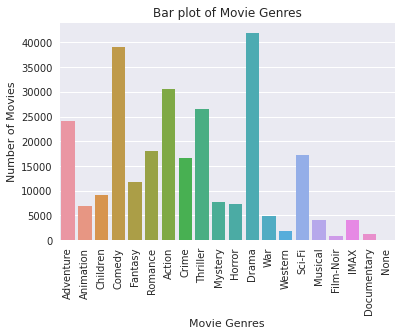

In [8]:
plt.style.use('seaborn-v0_8')
sns.barplot(x=genres_df['genres'], y=genres_df['count'])
plt.title('Bar plot of Movie Genres')
plt.xticks(rotation=90)
plt.xlabel('Movie Genres')
plt.ylabel('Number of Movies')
plt.show()

#### Observations

Drama is the most popular genre available in this dataset

### Most Rated Movies

In [9]:
df_ratings_agg = pd.DataFrame(df.groupby('title')['rating'].mean())
df_ratings_agg['total ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
df_ratings_agg.rename(columns={'rating': 'mean rating'}, inplace=True)
df_ratings_agg.sort_values('total ratings', ascending=False).head()

,mean rating,total ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278


#### Observation:
Forest Gump is the the most rated movie

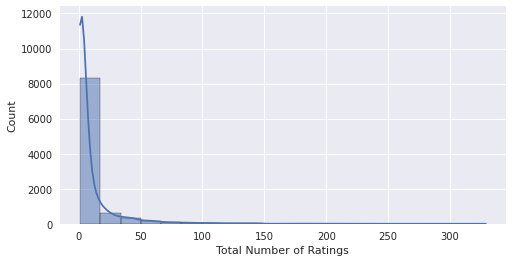

In [10]:
plt.figure(figsize=(8,4))
sns.histplot(df_ratings_agg['total ratings'], bins=20, kde=True)
plt.xlabel('Total Number of Ratings')
plt.show()

#### Observation:
Majority of movies have less that 50 ratings and the top 3 movies have over 300 ratings

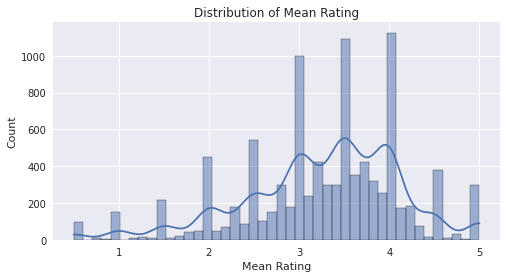

In [11]:
plt.figure(figsize=(8,4))
sns.histplot(df_ratings_agg['mean rating'], bins='auto', kde=True)
plt.title('Distribution of Mean Rating')
plt.xlabel('Mean Rating')
plt.show()

#### Observation
This is a mild left-skewed distribution in mean ratings with most ratings means at 3.5/5 and 4/5

## Create User-Item Matrix

In [12]:
user_item_matrix = pd.pivot_table(df, index='userId', columns='title', values='rating')
print(user_item_matrix.head())

title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
1              NaN                                      NaN   
2              NaN                                      NaN   
3              NaN                                      NaN   
4              NaN                                      NaN   
5              NaN                                      NaN   

title   'Round Midnight (1986)  'Salem's Lot (2004)  \
userId                                                
1                          NaN                  NaN   
2                          NaN                  NaN   
3                          NaN                  NaN   
4                          NaN                  NaN   
5                          NaN                  NaN   

title   'Til There Was You (1997)  'Tis the Season for Love (2015)  \
userId                                                               
1                             Na

### User-based Collaborative Filtering

#### Fill the row-wise NaNs in the User-Item Matrix with the corresponding user's mean ratings, and find the Pearson correlation between users

In [13]:
user_matrix = user_item_matrix.copy()

In [14]:
# Fill NaN values with user mean ratings
user_matrix_filled = user_item_matrix.T.fillna(user_item_matrix.T.mean()).T

# Display the matrix after filling NaNs
print(user_matrix_filled.head(5))

title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
1         4.366379                                 4.366379   
2         3.948276                                 3.948276   
3         2.435897                                 2.435897   
4         3.555556                                 3.555556   
5         3.636364                                 3.636364   

title   'Round Midnight (1986)  'Salem's Lot (2004)  \
userId                                                
1                     4.366379             4.366379   
2                     3.948276             3.948276   
3                     2.435897             2.435897   
4                     3.555556             3.555556   
5                     3.636364             3.636364   

title   'Til There Was You (1997)  'Tis the Season for Love (2015)  \
userId                                                               
1                        4.36637

In [15]:
user_corr= user_matrix_filled.T.corr()

### Choose the correlation of all users with only User 1

In [16]:
user1_corr = user_corr.iloc[0]

#### Sort the User 1 correlation in the descending order

In [17]:
user1_corr.sort_values(ascending=False, inplace=True)

#### Drop the NaN values generated in the correlation matrix

In [18]:
user1_corr.dropna(inplace=True)

### Choose the top 50 users that are highly correlated to User 1


In [19]:
top_50_corr_users = user1_corr[1:51]
print(top_50_corr_users)

userId
301    0.124799
597    0.102631
414    0.101348
477    0.099217
57     0.099070
369    0.098295
206    0.096852
535    0.096493
590    0.095191
418    0.094153
120    0.092770
75     0.091987
577    0.089396
198    0.088883
160    0.088133
226    0.088068
266    0.086064
312    0.086017
19     0.085249
135    0.084672
484    0.084350
469    0.084184
72     0.083613
593    0.082403
44     0.081400
297    0.080839
434    0.078361
483    0.078085
449    0.077631
552    0.077630
171    0.077241
199    0.076905
45     0.076489
608    0.075224
494    0.073544
116    0.073329
450    0.072014
201    0.071913
387    0.071418
173    0.071317
600    0.069528
513    0.069213
524    0.069208
368    0.069179
555    0.068507
180    0.067516
445    0.067329
20     0.066990
307    0.066782
480    0.066395
Name: 1, dtype: float64


#### Observations
Users 301,597 and 414 and the most closely correlated to User 1

### Predict the rating that User 1 might give for the movie with movieid 32 based on the top 50 user correlation matrix
(Hint: Predicted rating = sum of [(weights) * (ratings)] / sum of (weights ). Here, weights is the correlation of the corresponding user with the first user). That is, the predicted ratingis calculated as the weighted average of k similar users

In [20]:
# Name of Movie ID 32
movies_df['title'][movies_df['movieId']==32].values 

array(['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)'], dtype=object)

In [21]:
# Movies Rated by User 1
print(df[df['userId']==1])

# Users that rated Twelve Monkeys
print(df[df['movieId']== 32])

       userId  movieId  rating  timestamp                           title  \
0           1        1     4.0  964982703                Toy Story (1995)   
215         1        3     4.0  964981247         Grumpier Old Men (1995)   
267         1        6     4.0  964982224                     Heat (1995)   
369         1       47     5.0  964983815     Seven (a.k.a. Se7en) (1995)   
572         1       50     5.0  964982931      Usual Suspects, The (1995)   
...       ...      ...     ...        ...                             ...   
16056       1     3744     4.0  964980694                    Shaft (2000)   
16075       1     3793     5.0  964981855                    X-Men (2000)   
16208       1     3809     4.0  964981220          What About Bob? (1991)   
16243       1     4006     4.0  964982903  Transformers: The Movie (1986)   
16250       1     5060     5.0  964984002    M*A*S*H (a.k.a. MASH) (1970)   

                                            genres  
0      Adventure|Anima

#### Observations
As seen above, User 1 has not seen Twelve Monkeys. Predicting User 1's rating of Twelve Monkeys can be done 2 ways: using data with missing values synthetically filled ratings with ratings based on the mean ratings of the corresponding user or only including the correlations of the users that did rate the movie. 

Predicted rating = sum of [(weights) * (ratings)] / sum of (weights ). Here, weights is
the correlation of the corresponding user with the first user). That is, the predicted rating
is calculated as the weighted average of k similar users

In [22]:
top_50_users = top_50_corr_users.keys() # user IDs of the top 50 users correlated to user 1

### Method 1: fill in NaNs with user's mean ratings

In [23]:
ratings_top_50_users = user_matrix_filled.loc[top_50_corr_users.index,'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']
weights = top_50_users.values
weighted_sum = (ratings_top_50_users * weights).sum()
weights_sum = weights.sum()
predicted_rating = weighted_sum / weights_sum
print("Predicted User 1 rating with filled means for Twelve Monkeys: ", predicted_rating)

Predicted User 1 rating with filled means for Twelve Monkeys:  3.8220821694323943


### Method 2: Predicting using only users that actually saw and rated Movie 32

In [24]:
# Twelve Monkeys mean rating and total ratings
df_ratings_agg.loc[['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']]

,mean rating,total ratings
title,,
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),3.983051,177


In [25]:
count = 0
users = list() 
for user in top_50_users:
    # Filter each user in top 50 that rated movie 32
    if df[(df['userId']==user) & (df['movieId']==32)]['rating'].sum():
        count += 1
        users.append(user)
print(f'Total users that rated Twelve Monkeys: {count}')

Total users that rated Twelve Monkeys: 30


In [26]:
def predict_rating():
    sum_similarity = 0
    weighted_ratings = 0
    for user in users:
        weighted_ratings += top_50_corr_users.loc[user] * df[(df['userId']==user) & (df['movieId']==32)]['rating'].sum()
        sum_similarity += top_50_corr_users.loc[user]

    return(weighted_ratings/sum_similarity)
print(f'Predicted User 1 rating for Twelve Monkeys {predict_rating()}')

Predicted User 1 rating for Twelve Monkeys 4.1368953015974315


#### Observation
Method 2 has a higher rating is likely more accurate to what User 1 might rate for this specific type of movie because users are filtered to only the ones that watch it and are less likely to be skewed by the data synthetically added that pertain to ratings of ALL movies. 

## Item-based Collaborative Filtering

In [27]:
item_matrix = user_item_matrix.copy()

In [28]:
item_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


### Fill the column-wise NaN's in the User-Item Matrix with the corresponding movie's mean ratings, and find Pearson correlation between movies

In [29]:
item_matrix_filled = item_matrix.apply(lambda col: col.fillna(col.mean()), axis=0) #fill in missing values with movie's average rating

### Choose the correlation of all movies with the movie Jurassic Park (1993) only


### Sort the Jurassic Park movie correlation in descending order

In [30]:
movie_corr = item_matrix_filled.corr()

In [31]:
jurassic_corr = movie_corr["Jurassic Park (1993)"].dropna().sort_values(ascending=False)

### Find 10 movies similar to the movie Jurassic Park (1993)

In [32]:
similar_movies = jurassic_corr.drop(labels=["Jurassic Park (1993)"]).head(10)
print(similar_movies)

title
Fugitive, The (1993)                           0.324717
Lethal Weapon (1987)                           0.318646
Independence Day (a.k.a. ID4) (1996)           0.263629
Mission: Impossible (1996)                     0.258080
Ghostbusters (a.k.a. Ghost Busters) (1984)     0.256527
Mulan (1998)                                   0.255672
Rise of the Planet of the Apes (2011)          0.248134
Bug's Life, A (1998)                           0.240964
Indiana Jones and the Temple of Doom (1984)    0.239826
Die Hard (1988)                                0.239294
Name: Jurassic Park (1993), dtype: float64


#### Observations
Above are the top 10 movies most similar to Jurassic park. Most of the movies are made within the late 1980s-early 1990s with the exception of Rise of the Planet of the Apes, which came out in 2011

## Perform KNNBasic, SVD, NMF Model-based Collaborative Filtering
Initialize KNNBasic with similarity configuration as Mean Squared Distance Similarity (msd), 20 neighbors and cross-validate 5 folds against measure RMSE.
(Hint: cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True))


In [33]:
from surprise import Reader, Dataset, KNNBasic, SVD, NMF
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate
from surprise import accuracy

In [34]:
# Load the ratings dataset
ratings = pd.read_csv('ratings.csv')  # Adjust the path as necessary
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

## K-Nearest Neighbours (KNN)

In [35]:
# KNNBasic Model
knn_algo = KNNBasic(sim_options={'name': 'msd'})
knn_cv_results = cross_validate(knn_algo, data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9554  0.9393  0.9495  0.9447  0.9476  0.9473  0.0053  
Fit time          0.05    0.06    0.06    0.07    0.06    0.06    0.00    
Test time         0.71    0.71    0.79    0.74    0.78    0.75    0.03    


In [36]:
n_neighbors = [10, 20, 30]
param_grid = {'n_neightbors': n_neighbors}

gs = GridSearchCV(KNNBasic, param_grid, measures=['RMSE'])
gs.fit(data)


knn_best_score_gs = gs.best_score['rmse']
knn_best_params_gs = gs.best_params['rmse']


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

### Initialize Singular Value Decomposition (SVD) and cross-validate 5 folds against measure RMSE.


In [37]:
# SVD Model
svd_algo = SVD()
svd_cv_results = cross_validate(svd_algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8831  0.8758  0.8727  0.8710  0.8688  0.8743  0.0050  
Fit time          3.64    3.65    3.64    3.63    3.62    3.64    0.01    
Test time         0.17    0.10    0.17    0.10    0.10    0.13    0.04    


In [38]:
param_grid = {'n_factors': [50, 75], 'lr_all': [0.005, 0.05], 'reg_all': [0.06, 0.04]}

gs = GridSearchCV(algo_class=SVD, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

svd_best_score_gs = gs.best_score['rmse']
svd_best_params_gs = gs.best_params['rmse']

### Initialize Non-Negative Matrix Factorization (NMF) and cross-validate 5 folds against measure RMSE.


In [39]:
# NMF Model
nmf_algo = NMF()
nmf_cv_results = cross_validate(nmf_algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9194  0.9100  0.9245  0.9214  0.9168  0.9184  0.0049  
Fit time          4.14    4.24    4.33    4.16    4.18    4.21    0.07    
Test time         0.08    0.17    0.08    0.08    0.08    0.10    0.04    


### Print best score and best params from Cross Validate on all the models built.

In [40]:
knn_best_score = knn_cv_results['test_rmse'].mean()
svd_best_score = svd_cv_results['test_rmse'].mean()
nmf_best_score = nmf_cv_results['test_rmse'].mean()

# Print best cv scores for each model 
print(f"KNNBasic Mean RMSE: {knn_best_score:.4f}")
print(f"SVD Mean RMSE: {svd_best_score:.4f}")
print(f"NMF Mean RMSE: {nmf_best_score:.4f}")

# Best scores after hypertuning
print(f"KNNBasic RMSE: {knn_best_score_gs:.4f}")
print(f"SVD RMSE: {svd_best_score_gs:.4f}")

KNNBasic Mean RMSE: 0.9473
SVD Mean RMSE: 0.8743
NMF Mean RMSE: 0.9184
KNNBasic RMSE: 0.9475
SVD RMSE: 0.8641


## Conclusion
- User based CF enables prediction of the rating of User 1 for a movie he/she has not seen based on similar users
- Item based CF enables recommendation of a movie based on movie similarity
- In case of Model Based CF, from the score, SVD gives the best performance with least RMSE mean score from 5 folds of ~87% after hyperparameter tuning.